## Building the Ship

In [94]:
import random

d = 40

#Helper method to check neighbors in board initialization
def checkNeighbors(grid, r, c, a):
    return [grid[r-1][c],grid[r+1][c],grid[r][c-1],grid[r][c+1]].count(a)

#Create new board with given edge length
def createBoard(d):
    grid = [[0 for _ in range(d+2)] for _ in range(d+2)]

    for j in range(d+2):
        grid[0][j] = 2 
        grid[d+1][j] = 2 
    for i in range(d+2):
        grid[i][0] = 2 
        grid[i][d+1] = 2
    x = random.randint(1, d)
    y = random.randint(1, d)

    fringe = []
    fringe.append((x,y))

    deadEnds = []

    while len(fringe) > 0:
        curr = random.choice(fringe)
        fringe.remove(curr)
        r, c = curr[0], curr[1]
        if checkNeighbors(grid, r, c, 1) > 1:
            continue
        grid[r][c] = 1
        up = (r-1, c) 
        down = (r+1, c) 
        left = (r, c-1) 
        right = (r, c+1)
        deadEnd = True
        for elt in [up, down, left, right]:
            if grid[elt[0]][elt[1]] == 0:
                numOpenNeighbors = checkNeighbors(grid, elt[0], elt[1], 1)
                if numOpenNeighbors == 1:
                    deadEnd = False
                    fringe.append(elt)
        if deadEnd:
            deadEnds.append(curr)
        
    count = 0   
    for row in grid:
        count += row.count(1)
    print(f"Percent of cells opened: {100*count/(d*d)}")
    return grid

board implementation details here if youd like

In [95]:
grid = createBoard(d)

Percent of cells opened: 61.5625


In [96]:
import matplotlib.pyplot as plt
import numpy as np

color_map_3 = {
    0: 'white',
    1: 'black',
    2: 'red'
}

color_map_7 = {
    0: 'white',
    1: 'black',
    2: 'red',
    3: 'orange',
    4: 'blue',
    5: 'purple',
    6: 'yellow'
}

def visualizeGrid(color_map, grid):
    fig, ax = plt.subplots()

    for i in range(len(grid)):
        for j in range(len(grid[i])):
            ax.add_patch(plt.Rectangle((j, i), 1, 1, facecolor=color_map[grid[i][j]]))

    ax.set_xlim(0, len(grid[0]))
    ax.set_ylim(0, len(grid))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

    plt.gca().invert_yaxis() 
    plt.show()

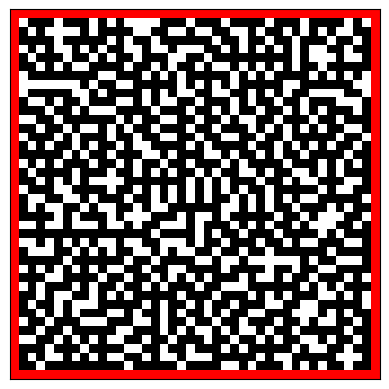

In [97]:
visualizeGrid(color_map_3, grid)

black = open cells, red = wall

## Coding the Fire


In [98]:
def setFire(grid, pt, q):
    if grid[pt[0]][pt[1]] == 3:
        return
    k = checkNeighbors(grid, pt[0], pt[1], 3)
    prob = 1 - (1-q)**k
    x = random.random()
    if x <= prob:
        grid[pt[0]][pt[1]] = 3
    return

In [99]:
def spreadFire(grid, fireLocs, q, df=None, i=None, timestep=None):
    fireLocsNew = []
    for curr in fireLocs:
        if grid[curr[0]][curr[1]] == 2:
            fireLocs.remove(curr)
            continue
        setFire(grid, curr, q)
        if grid[curr[0]][curr[1]] == 3:
            fireLocs.remove(curr)
            if df is not None and i is not None and timestep is not None:
                df.loc[curr][i] = timestep
            neighbors = [(curr[0]-1,curr[1]), (curr[0]+1,curr[1]), (curr[0], curr[1]-1), (curr[0], curr[1]+1)]
            for elt in neighbors:
                if grid[elt[0]][elt[1]] == 1 or grid[elt[0]][elt[1]] == 4:
                    fireLocsNew.append(elt)
    fireLocs.extend(fireLocsNew)
    return fireLocs

In [100]:
def reset_grid(grid):
    for i in range(len(grid)):  # Iterate through rows
            for j in range(len(grid[i])):  # Iterate through columns
                if (grid[i][j] in range(3,7)):
                    grid[i][j] = 1
#     grid[fireLoc[0]][fireLoc[1]] = 3

## Location Initializations

In [101]:
def location_initialization(grid, botLoc=None, butLoc=None, fireLoc=None):
    botLoc = (random.randint(1, d), random.randint(1, d))
    while grid[botLoc[0]][botLoc[1]] == 0:
        botLoc = (random.randint(1, d), random.randint(1, d))

    butLoc = (random.randint(1, d), random.randint(1, d))
    while grid[butLoc[0]][butLoc[1]] == 0:
        butLoc = (random.randint(1, d), random.randint(1, d))

    fireLoc = (random.randint(1, d), random.randint(1, d))
    while grid[fireLoc[0]][fireLoc[1]] == 0:
        fireLoc = (random.randint(1, d), random.randint(1, d))

    notDistinct = (botLoc == butLoc) or (botLoc == fireLoc) or (butLoc == fireLoc)
    #print(distinct)

    while notDistinct:
        while grid[botLoc[0]][botLoc[1]] == 0:
            botLoc = (random.randint(1, d), random.randint(1, d))
        while grid[butLoc[0]][butLoc[1]] == 0:
            butLoc = (random.randint(1, d), random.randint(1, d))
        while grid[fireLoc[0]][fireLoc[1]] == 0:
            fireLoc = (random.randint(1, d), random.randint(1, d))
    
    return botLoc,butLoc,fireLoc

note - for every new board we create we need to run createboard AND location_initialization

In [102]:
botLoc,butLoc,fireLoc = location_initialization(grid)
print(f"Bot Location: {botLoc}")
print(f"Button Location: {butLoc}")
print(f"Fire Location: {fireLoc}")

Bot Location: (16, 40)
Button Location: (9, 2)
Fire Location: (39, 27)


## Shortest Path (Bot 1)

In [103]:
import copy

bot1Grid = copy.deepcopy(grid)
bot1Grid[fireLoc[0]][fireLoc[1]] = 3

def shortestBot1(grid, botLoc, fireLocs, butLoc):
    fringe1 = []
    fringe1.append(botLoc)

    closed_set = {}
    prev1 = {}
    prev1[botLoc] = None

    while len(fringe1) > 0:
        curr1 = fringe1.pop(0)
        if curr1 == butLoc:
            #print(curr1)
#             print("Success")
            break

        if curr1 not in closed_set:
            closed_set.update({curr1: 1})
            r1, c1 = curr1[0], curr1[1]
            neighbors1 = [(r1-1, c1),(r1+1, c1),(r1, c1-1),(r1, c1+1)]
            for elt in neighbors1:
                if bot1Grid[elt[0]][elt[1]] == 1 and elt not in closed_set:
                    fringe1.append(elt)
                    prev1[elt] = curr1
    #print(prev1)

    path = []
    curr = butLoc
    while curr is not None:
        path.append(curr)
        curr = prev1[curr]

    # Return the path from start to finish
#     path = path[::-1]  # Reverse the path to go from start to finish
    return path[::-1]


## Game Loop (Bot 1)

In [104]:
def gameLoop1(grid, botLoc, fireLoc, butLoc, trackTime, q):
    t = 1
    fireLocs = []
    r,c = fireLoc[0], fireLoc[1]
    grid[r][c] = 3
    fireLocs.extend(((r-1, c), (r+1, c), (r,c-1), (r,c+1)))
    success = True
    path = shortestBot1(bot1Grid, botLoc, fireLocs, butLoc)
    for i in path[1:]:
        fireLocs = spreadFire(bot1Grid, fireLocs, q)
        if bot1Grid[i[0]][i[1]] == 3:
            if trackTime: print(f"Bot1 failed in {t} timesteps.")
            success = False
            break
        t = t + 1
        bot1Grid[i[0]][i[1]] = 4
    l = len(path)
    bot1Grid[butLoc[0]][butLoc[1]] = 5
    bot1Grid[fireLoc[0]][fireLoc[1]] = 6
    return success
success_1 = gameLoop1(bot1Grid, botLoc, fireLoc, butLoc, True, 0.5)
if success_1: print("Success!")

Success!


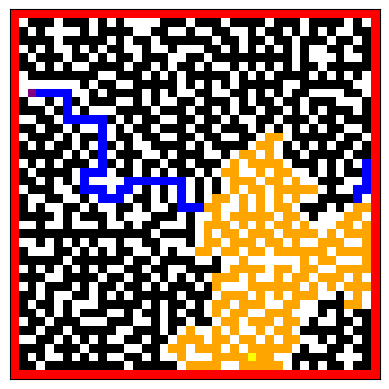

In [105]:
visualizeGrid(color_map_7, bot1Grid)

The yellow dot represents the source of the fire. The pink dot represents the button.

In [106]:
reset_grid(bot1Grid)

## Shortest Path (Bot 2)

In [107]:
def shortestBot2(grid, botLoc, fireLocs, butLoc, i, path):
    currentFires = set([])
    currentFires.add(fireLoc)
    for row in range(len(grid)):
        for col in range(len(grid[row])):
            if grid[row][col] == 3:
                currentFires.add((row, col))
    fringe1 = []
    fringe1.append(botLoc)

    closed_set = {}
    prev1 = {}
    prev1[botLoc] = None
    success = False

    while len(fringe1) > 0:
        curr1 = fringe1.pop(0)
        if curr1 == butLoc:
            #print(curr1)
            success = True
            break

        if curr1 not in closed_set:
            closed_set.update({curr1: 1})
            r1, c1 = curr1[0], curr1[1]
            neighbors1 = [(r1-1, c1),(r1+1, c1),(r1, c1-1),(r1, c1+1)]
            for elt in neighbors1:
                if (grid[elt[0]][elt[1]] == 1 or grid[elt[0]][elt[1]] == 4) and elt not in closed_set and elt not in currentFires:
                    fringe1.append(elt)
                    prev1[elt] = curr1
    #print(prev1)
    if not success: 
        return path

    path2 = []
    curr = butLoc
#     print(prev1)
    while curr is not None:
        path2.append(curr)
        curr = prev1[curr]
    path2 = path2[::-1]
    if path2 != path[i:]:
        path[i:] = path2

    # Return the path from start to finish
    return path  # Reverse the path to go from start to finish

## Game Loop (Bot 2)

In [108]:
bot2Grid = copy.deepcopy(grid)
bot2Grid[fireLoc[0]][fireLoc[1]] = 3

def gameLoop2(grid, botLoc, fireLoc, butLoc, trackTime, q):
    t = 1
    fireLocs = []
    r,c = fireLoc[0], fireLoc[1]
    grid[r][c] = 3
    fireLocs.extend(((r-1, c), (r+1, c), (r,c-1), (r,c+1)))
    success = True
    pathBot2 = []
    pathBot2.append(botLoc)
    pathBot2 = shortestBot2(bot2Grid, botLoc, fireLocs, butLoc, 0, pathBot2)
    i = 1
    while i < len(pathBot2):
        fireLocs = spreadFire(bot2Grid, fireLocs, q)
        if bot2Grid[pathBot2[i][0]][pathBot2[i][1]] == 3:
            if trackTime: 
                print(f"Bot2 failed in {t} timesteps.")
            success= False
            break
        bot2Grid[pathBot2[i][0]][pathBot2[i][1]] = 4
        pathBot2 = shortestBot2(bot2Grid, pathBot2[i], fireLocs, butLoc, i, pathBot2)
        t = t + 1
        i = i + 1
#     l = len(path)
    bot2Grid[butLoc[0]][butLoc[1]] = 5
    bot2Grid[fireLoc[0]][fireLoc[1]] = 6
    return success
success_2 = gameLoop2(bot2Grid, botLoc, fireLoc, butLoc, True, 0.5)
if success_2: print(f"Success!")

Success!


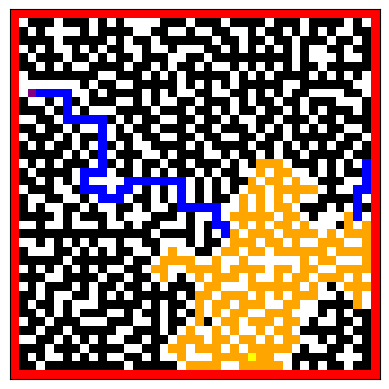

In [109]:
visualizeGrid(color_map_7, bot2Grid)

In [110]:
reset_grid(bot2Grid)

## Shortest Path (Bot 3)

In [111]:
def shortestBot3(grid, botLoc, fireLocs, butLoc, i, path):
    fringe1 = []
    fringe1.append(botLoc)

    closed_set = {}
    prev1 = {}
    prev1[botLoc] = None
    success = False

    while len(fringe1) > 0:
        curr1 = fringe1.pop(0)
        if curr1 == butLoc:
            #print(curr1)
            success = True
            break

        if curr1 not in closed_set:
            closed_set.update({curr1: 1})
            r1, c1 = curr1[0], curr1[1]
            neighbors1 = [(r1-1, c1),(r1+1, c1),(r1, c1-1),(r1, c1+1)]
            for elt in neighbors1:
                if (grid[elt[0]][elt[1]] == 1 or grid[elt[0]][elt[1]] == 4) and elt not in closed_set and (elt not in fireLocs or elt == butLoc):
                    fringe1.append(elt)
                    prev1[elt] = curr1
    #print(prev1)
    if not success: 
        return path

    path2 = []
    curr = butLoc
#     print(prev1)
    while curr is not None:
        path2.append(curr)
        curr = prev1[curr]
    path2 = path2[::-1]
    if path2 != path[i:]:
        path[i:] = path2

    # Return the path from start to finish
    return path  # Reverse the path to go from start to finish

## Game Loop (Bot 3)

In [112]:
bot3Grid = copy.deepcopy(grid)
bot3Grid[fireLoc[0]][fireLoc[1]] = 3

def gameLoop3(grid, botLoc, fireLoc, butLoc, trackTime, q):
    t = 1
    fireLocs = []
    r,c = fireLoc[0], fireLoc[1]
    grid[r][c] = 3
    fireLocs.extend(((r-1, c), (r+1, c), (r,c-1), (r,c+1)))
    success = True
    pathBot3 = []
    pathBot3.append(botLoc)
    pathBot3 = shortestBot3(bot3Grid, botLoc, fireLocs, butLoc, 0, pathBot3)
    i = 1
    while i < len(pathBot3):
        fireLocs = spreadFire(bot3Grid, fireLocs, q)
        if bot3Grid[pathBot3[i][0]][pathBot3[i][1]] == 3:
            if trackTime:
                print(f"Bot3 failed in {t} timesteps.")
            success= False
            break
        bot3Grid[pathBot3[i][0]][pathBot3[i][1]] = 4
        pathBot3 = shortestBot3(bot3Grid, pathBot3[i], fireLocs, butLoc, i, pathBot3)
        t = t + 1
        i = i + 1
#     l = len(path)
    bot3Grid[butLoc[0]][butLoc[1]] = 5
    bot3Grid[fireLoc[0]][fireLoc[1]] = 6
    return success

count = 0
for i in range(10):
    botLoc,butLoc,fireLoc = location_initialization(grid)
    reset_grid(bot3Grid)
    success = gameLoop3(bot3Grid, botLoc, fireLoc, butLoc, False, 1)
    print(success)
    if success:
        count += 1
print(count/10)

True
True
True
False
True
False
False
False
True
True
0.6


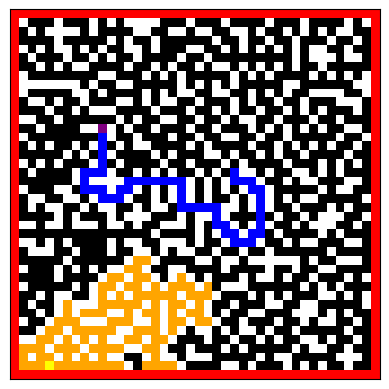

In [113]:
visualizeGrid(color_map_7, bot3Grid)

In [114]:
reset_grid(bot3Grid)

## Bot 4 Logic
The expression that represents the probability of a given cell being set on fire is:
$$
1-(1-q)^K
$$
where
$q = \text{ship flammability,}$
$K = \text{number of on-fire neighbors.}$

Our approach for Bot 4 will be an implementation of Dijkstra's Shortest-Path Algorithm in which our cost function will take in a given cell's probability of being set on fire several steps in advance. There are a few ways to perform this:
1. Markov Chain Monte Carlo Method: Before starting the algorithm, simulate the fire spreading throughout the grid $n$ times. Create a dataframe that records each open cell and which timestep $t_i$ for $i=1,...,n$ it was set on fire, with cells as rows and simulations as columns. We will be able to estimate the likelihood of a given cell being on fire by a given timestep by taking the rate of being on fire out of all simulations (shown below). This will give an estimate for the true distribution of probabilities for each cell. Then, when running Dijkstra's, when considering a cell for exploration, we take into account its calculated probability.
2. For each iteration of Dijkstra's, given a cell being considered, mathematically calculate its probability that it will be set on fire by a certain timestep. This is possible but would be more expensive than simulation.

We will choose option 1 with cost function $$C(node)=c*p(node)*d$$ 
where 
$$c=\text{some constant},$$
$$p(\text{node on fire}|t)=\frac{1}{n}\sum_{i=1}^{n} 1 (t_i\leq t),$$
$$d=\text{Manhattan distance from node to button.}$$

Note that using the Manhattan distance is a relaxation of the problem, as it assumes that every cell between the bot and the button is open.

Also note that the constant $c$ allows us to quantify how risk-averse we want to be. A higher $c$ will punish higher probabilities and higher estimated distances. For now we will set $c=1$.

## Bot 4 Data Collection

In [115]:
def simulateFire(grid, fireLoc, df, numSims, q):
    r,c = fireLoc[0], fireLoc[1]
    for i in range(numSims):
        grid[r][c] = 3
        fireLocs = []
        fireLocs.extend(((r-1, c), (r+1, c), (r,c-1), (r,c+1)))
        t = 0
        while len(fireLocs) > 0:
            fireLocs = spreadFire(grid, fireLocs, q, df, i, t)
            t = t + 1
        reset_grid(grid)
    return df

In [116]:
def p(pt, df, t):
    return ((df.loc[pt] <= t).sum() / len(df.columns))

In [117]:
def d_manhattan(pt, butLoc):
    return abs(butLoc[0]-pt[0]) + abs(butLoc[1]-pt[1])

In [118]:
def C(pt, df, t, butLoc):
    return 2 * p(pt, df, t) * d_manhattan(pt, butLoc)

In [119]:
import itertools
import pandas as pd

bot4Grid = copy.deepcopy(grid)
def simulateBot4(grid, fireLoc, q):
    numSims = 15
    cells = list(itertools.product(range(1, 41), repeat=2))
    df = pd.DataFrame(0, index=pd.MultiIndex.from_tuples(cells, names=["Row", "Col"]),
                      columns=[f'Sim_{i+1}' for i in range(numSims)])
    df = simulateFire(grid, fireLoc, df, numSims, q)
    return df

df = simulateBot4(bot4Grid, fireLoc, 0.5)
print(df.head())

C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

         Sim_1  Sim_2  Sim_3  Sim_4  Sim_5  Sim_6  Sim_7  Sim_8  Sim_9  \
Row Col                                                                  
1   1        0      0      0      0      0      0      0      0      0   
    2      310    302    287    300    328    327    271    301    342   
    3      308    301    285    299    327    320    265    299    341   
    4      312    303    286    301    330    324    266    302    344   
    5        0      0      0      0      0      0      0      0      0   

         Sim_10  Sim_11  Sim_12  Sim_13  Sim_14  Sim_15  
Row Col                                                  
1   1         0       0       0       0       0       0  
    2       337     269     332     315     286     304  
    3       336     265     330     311     285     300  
    4       338     266     331     312     289     301  
    5         0       0       0       0       0       0  


In [120]:
# Test it out
sampleLocation = (15,25)
print(f"Estimated cost of going to {sampleLocation} by 150 timesteps: {C(sampleLocation, df, 150, butLoc)}")

Estimated cost of going to (15, 25) by 150 timesteps: 2.2666666666666666


## Shortest Path (Bot 4)

In [121]:
from queue import PriorityQueue as pq

def shortestBot4(grid, botLoc, butLoc, df):
    fringe4 = pq()
    fringe4.put((0.0, botLoc))

    dist = {}
    dist[botLoc] = 0

    prev4 = {}
    prev4[botLoc] = None
    
    time = {}
    time[botLoc] = 0

#     t = 1

    while fringe4.qsize() > 0:
        curr = fringe4.get()
        curr1 = curr[1]
        priority = curr[0]
        if curr1 == butLoc:
#             print("Success")
            break
        t = time[curr1]
        r1, c1 = curr1[0], curr1[1]
        neighbors1 = [(r1-1, c1),(r1+1, c1),(r1, c1-1),(r1, c1+1)]
        for elt in neighbors1:
            if (elt[0] < 1 or elt[0] > 40) or (elt[1] < 1 or elt[1] > 40):
                continue
            elt_cost = C(elt, df, t+1, butLoc)
            if (bot4Grid[elt[0]][elt[1]] == 1 and (elt == butLoc or elt not in dist or elt_cost < dist[elt])):
                fringe4.put((elt_cost, elt))
                dist[elt] = elt_cost
                prev4[elt] = curr1
                time[elt] = t + 1

#         t = t + 1

    path4 = []
    curr = butLoc
    while curr is not None:
        path4.append(curr)
        curr = prev4[curr]

    # Return the path from start to finish
    return path4[::-1]

## Game Loop (Bot 4)

In [122]:
def gameLoop4(grid, botLoc, fireLoc, butLoc, trackTime, q):
    df = simulateBot4(grid, fireLoc, q=q)
    t = 1
    fireLocs = []
    r,c = fireLoc[0], fireLoc[1]
    fireLocs.extend(((r-1, c), (r+1, c), (r,c-1), (r,c+1)))
    success = True
    path4 = []
    path4 = shortestBot4(bot4Grid, botLoc, butLoc, df)
    grid[r][c] = 3
    for i in path4[1:]:
        if i == path4[-1]:
            break
        fireLocs = spreadFire(bot4Grid, fireLocs, q=q)
        if bot4Grid[i[0]][i[1]] == 3:
            if trackTime: 
                print(f"Bot4 failed in {t} timesteps.")
            success= False
            break
        t = t + 1
        bot4Grid[i[0]][i[1]] = 4
    # l = len(path4)
    bot4Grid[butLoc[0]][butLoc[1]] = 5
    bot4Grid[fireLoc[0]][fireLoc[1]] = 6
    return success


success_4 = gameLoop4(bot4Grid, botLoc, fireLoc, butLoc, True, 0.5)
if success_4: print("Success!")

C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Success!


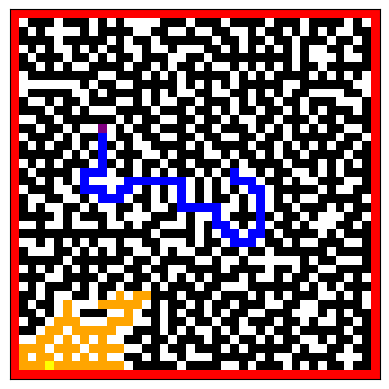

In [123]:
visualizeGrid(color_map_7, bot4Grid)

In [124]:
reset_grid(bot4Grid)

## Data Analysis

In [125]:
def does_path_exist(grid, fireLoc, butLoc, q):
    r,c = fireLoc[0], fireLoc[1]
    grid[fireLoc[0]][fireLoc[1]] = 3
    fireLocs = []
    fireLocs.extend(((r-1, c), (r+1, c), (r,c-1), (r,c+1)))
    while grid[butLoc[0]][butLoc[1]] != 3:
        fireLocs = spreadFire(grid, fireLocs, q)
    
    fringe = []
    fringe.append(botLoc)
    closed_set = {}
    
    while len(fringe) > 0:
        curr1 = fringe.pop(0)
        if curr1 == butLoc:
            reset_grid(grid)
            return True
            
        if curr1 not in closed_set:
            closed_set.update({curr1: 1})
            r1, c1 = curr1[0], curr1[1]
            neighbors1 = [(r1-1, c1),(r1+1, c1),(r1, c1-1),(r1, c1+1)]
            for elt in neighbors1:
                if bot1Grid[elt[0]][elt[1]] == 1 and elt not in closed_set:
                    fringe.append(elt)
                    
    reset_grid(grid)
    return False
# botLoc,butLoc,fireLoc = location_initialization(grid)
# print(does_path_exist(grid, fireLoc, butLoc, 0.5))

Run 1 out of 10 for q: 0.1
Percent of cells opened: 61.0625


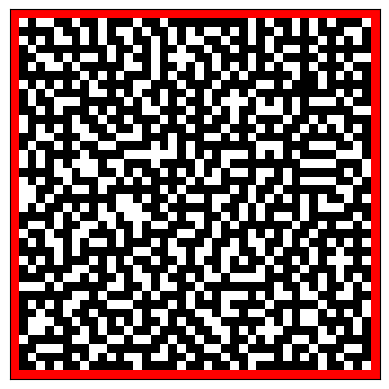

Bot location: (24, 27)
Fire starts at: (9, 33)
Button location: (20, 13)


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 2 out of 10 for q: 0.1
Percent of cells opened: 61.0


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 3 out of 10 for q: 0.1
Percent of cells opened: 61.0625


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 4 out of 10 for q: 0.1
Percent of cells opened: 61.125


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 5 out of 10 for q: 0.1
Percent of cells opened: 60.75


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 6 out of 10 for q: 0.1
Percent of cells opened: 60.875


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 7 out of 10 for q: 0.1
Percent of cells opened: 61.375


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 8 out of 10 for q: 0.1
Percent of cells opened: 60.375


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 9 out of 10 for q: 0.1
Percent of cells opened: 60.4375


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 10 out of 10 for q: 0.1
Percent of cells opened: 60.8125


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Bot1    0.8
Bot2    0.8
Bot3    0.8
Bot4    0.8
Name: 0.1, dtype: float64
Run 1 out of 10 for q: 0.3
Percent of cells opened: 60.4375


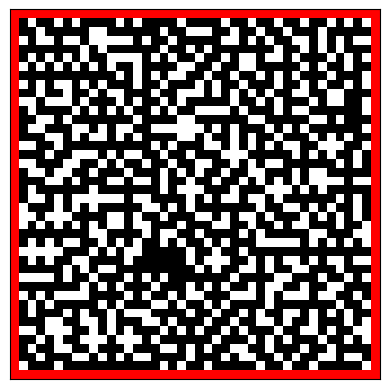

Bot location: (2, 36)
Fire starts at: (1, 16)
Button location: (9, 34)


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 2 out of 10 for q: 0.3
Percent of cells opened: 60.3125


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 3 out of 10 for q: 0.3
Percent of cells opened: 60.8125


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 4 out of 10 for q: 0.3
Percent of cells opened: 60.875


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 5 out of 10 for q: 0.3
Percent of cells opened: 60.875


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 6 out of 10 for q: 0.3
Percent of cells opened: 60.6875


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 7 out of 10 for q: 0.3
Percent of cells opened: 60.375


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 8 out of 10 for q: 0.3
Percent of cells opened: 60.8125


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 9 out of 10 for q: 0.3
Percent of cells opened: 60.375


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 10 out of 10 for q: 0.3
Percent of cells opened: 61.625


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Bot1    1.0
Bot2    0.9
Bot3    0.9
Bot4    0.9
Name: 0.3, dtype: float64
Run 1 out of 10 for q: 0.5
Percent of cells opened: 61.125


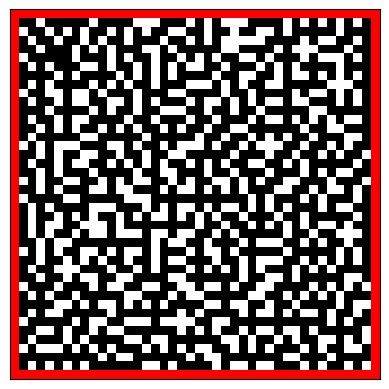

Bot location: (18, 28)
Fire starts at: (5, 5)
Button location: (3, 1)


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 2 out of 10 for q: 0.5
Percent of cells opened: 60.5625


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 3 out of 10 for q: 0.5
Percent of cells opened: 60.75


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 4 out of 10 for q: 0.5
Percent of cells opened: 60.125


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 5 out of 10 for q: 0.5
Percent of cells opened: 60.375


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 6 out of 10 for q: 0.5
Percent of cells opened: 60.25


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 7 out of 10 for q: 0.5
Percent of cells opened: 61.0


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 8 out of 10 for q: 0.5
Percent of cells opened: 60.0


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 9 out of 10 for q: 0.5
Percent of cells opened: 60.5625


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 10 out of 10 for q: 0.5
Percent of cells opened: 60.1875


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Bot1    0.9
Bot2    0.9
Bot3    0.9
Bot4    0.9
Name: 0.5, dtype: float64
Run 1 out of 10 for q: 0.7
Percent of cells opened: 61.0


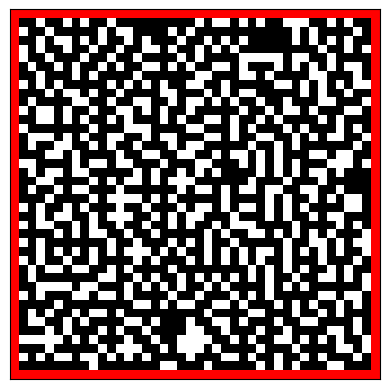

Bot location: (39, 37)
Fire starts at: (3, 29)
Button location: (33, 38)


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 2 out of 10 for q: 0.7
Percent of cells opened: 60.8125


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 3 out of 10 for q: 0.7
Percent of cells opened: 59.6875


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 4 out of 10 for q: 0.7
Percent of cells opened: 61.4375


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 5 out of 10 for q: 0.7
Percent of cells opened: 61.375


C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[curr][i] = timestep
C:\Users\ridu3\AppData\Local\Temp\ipykernel_57388\633059182.py:11: FutureWarning: Series.__setitem__ 

Run 6 out of 10 for q: 0.7
Percent of cells opened: 60.6875


KeyboardInterrupt: 

In [126]:
# q_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
q_list = [0.1, 0.3, 0.5, 0.7, 0.9]
success_df = pd.DataFrame(0, index=q_list, columns=['Bot1', 'Bot2', 'Bot3', 'Bot4'])
numRounds = 10
# numGridsForTesting = 5
# grids_for_testing = []
#we would envelppe this in a for g in grids_for_testing and save the data both for the aggregate bot statistics and for per board basis if we think there might be anything cool, might take too long though
for q in q_list:
    success_rates = [0.0,0.0,0.0,0.0]
    counts = [0,0,0,0]
    for i in range(numRounds):
        print(f"Run {i + 1} out of {numRounds} for q: {q}")
        
        grid_to_test = createBoard(d)
        botLoc,butLoc,fireLoc = location_initialization(grid_to_test)
        while not does_path_exist(grid_to_test, fireLoc, butLoc, q):
            botLoc,butLoc,fireLoc = location_initialization(grid_to_test)
        visualizeGrid(color_map_3, grid_to_test)
        print(f"Bot location: {botLoc}\nFire starts at: {fireLoc}\nButton location: {butLoc}")
        bot1Grid = copy.deepcopy(grid_to_test)
        bot2Grid = copy.deepcopy(grid_to_test)
        bot3Grid = copy.deepcopy(grid_to_test)
        bot4Grid = copy.deepcopy(grid_to_test)
            
        if gameLoop1(bot1Grid, botLoc, fireLoc, butLoc, False, q):
            counts[0] += 1
        # reset_grid(bot1Grid)
        print("Bot 1 done")
        if gameLoop2(bot2Grid, botLoc, fireLoc, butLoc, False, q):
            counts[1] += 1
        # reset_grid(bot2Grid)
        print("Bot 2 done")
        if gameLoop3(bot3Grid, botLoc, fireLoc, butLoc, False, q):
            counts[2] += 1
        # reset_grid(bot3Grid)
        print("Bot 3 done")
        if gameLoop4(bot4Grid, botLoc, fireLoc, butLoc, False, q):
            counts[3] += 1
        # reset_grid(bot4Grid)
        print("Bot 4 done")
    for bot in range(len(counts)):
        success_rates[bot] = counts[bot]/numRounds
    success_df.loc[q] = success_rates
    print(success_df.loc[q])

In [ ]:

# Plotting for each bot
for bot in ['Bot1', 'Bot2', 'Bot3', 'Bot4']:
    plt.figure()  # Create a new figure for each bot
    plt.plot(q_list, success_df[bot], marker='o')
    
    # Add labels and title
    plt.title(f'Success Rate for {bot}')
    plt.xlabel('q (flammability)')
    plt.ylabel('Success Rate')
    
    # Show the grid for clarity
    plt.grid(True)
    
    # Show the plot
    plt.show()
